<a href="https://colab.research.google.com/github/ayportella/projects_machine_learning/blob/main/01_projeto_extra_machine_learning_geochemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto de Machine Learning**

[Andressa Yumi Portella](https://www.linkedin.com/in/andressa-yumi-portella/)<br>
Maio de 2023

# **1. Coleta de Dados**

O dataset desse projeto é o [Regional Geochemical Survey Dataset](https://open.canada.ca/data/en/dataset/49a73c36-4a25-4be5-b6d1-abd020fb031a), um programa conduzido pelo Canadá desde 1976 para auxiliar a exploração e o desenvolvimento de recursos minerais no país. Foi escolhido o dataset geoquímico de dados de sedimentos de corrente. <br>
<br>
Sedimentos de corrente fazem parte do principal método de pesquisas regionais, indicando a litologia da área de drenagem e, consequentemente, o depósito mineral que ocorre a montante do rio.<br>
<br>
A ideia desse projeto é **prever as unidades geológicas** (Formação ou Grupo, classificação de rochas baseadas em suas características e idades, explicando de uma maneira simplificada) **a partir de concentração de alguns elementos químicos e dados de posicionamento** (latitude e longitude).<br>
<br>
Foram escolhidos os elementos químicos Chumbo (Pb), Zinco (Zn) e Cobre (Cu) baseados em pesquisa sobre a geologia do local da região de Quest, um platô em Prince George, Canadá. Trata-se de uma região com mineralizações de Cu-Au porfirítico, o que motivou a escolha desses elementos para a predição da estratigrafia.<br>
<br>
Teria sido importante usar o elemento químico Ouro (Au) como parâmetro no modelo, mas as concentrações desse elemento não estavam disponíveis no dataset para a região escolhida de Quest.

Houve a parte de limpeza dos dados em um editor de planilhas, com a filtragem dos dados da área de Quest, a região dentre todas as outras que tem o maior número de dados. 
<br>

Quest fica no platô central de Brithish Columbia, perto da cidade de Prince George. A geologia da área é caracterizada por sedimentos de idade variando entre o Cretáceo ao Oligoceno da Bacia de Nechako, que é rodeada por montanhas costeiras a oeste e a leste.   
<br>
Houve posterior remoção de linhas nas quais as unidades geológicas tinham menos de 30 ocorrências no dataset, sendo as escolhidas as seguintes (Kushnir et al. 2012):
<br>

LTQch : Chilcotin Group Volcanic Rocks (Neógeno)<br>
uTrJNc: Triassic to Jurassic Nicola group<br>
TrJTK: Triassic to Jurassic Takla Group<br>
MTrCc: Mississipian to Triassic Cacho Creek Group<br>
CPSm: Carboniferous to Permian Slide Mountain Group<br>
KTpg: Cretaceous to Paleogene intrusive and high-grade metamorphic rocks<br>

Ou seja, as 5 primeiras litologias acima correspondem a rochas estratificadas, e a última, a intrusões de alto grau metamórfico.



Mapa Geológico Simplificado de Nechako Basin e Regiões Adjacentes<br>
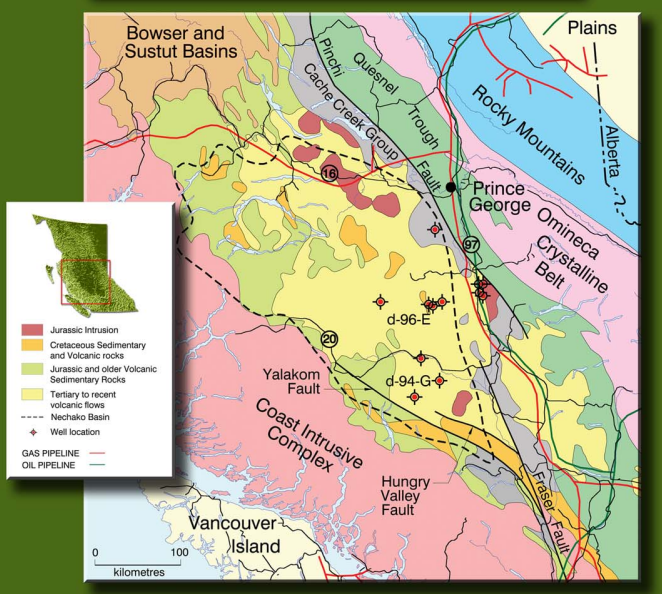

Seção Geológica simplificada da porção central de Nechako Basin<br>
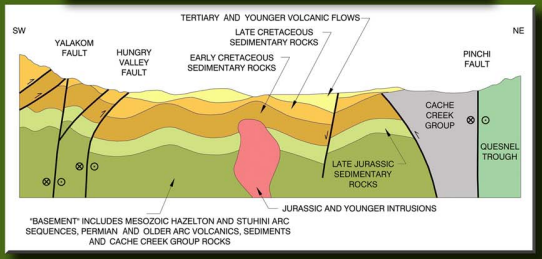

In [3]:
#importando bibliotecas
import sklearn
import sklearn.metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#lendo o arquivo csv
quest = pd.read_csv('questdata2.csv')

In [7]:
#vendo as 5 primeiras linhas do dataset
quest.head(5)

,LAT,LONG,STRAT,Cu_ICP_PPM,Pb_ICP_PPM,Zn_ICP_PPM
0,53.61138,-122.97780,LTQCh,48.56,5.77,81.7
1,53.62691,-122.96569,LTQCh,27.40,4.51,21.5
2,53.65023,-122.98068,LTQCh,43.50,5.51,111.6
3,53.66609,-123.02010,LTQCh,56.89,7.99,86.8
4,53.63407,-122.99388,LTQCh,53.25,9.17,99.4


 **1.1. Análise Exploratória**

Os gráficos abaixo ajudarão a entender melhor a relação entre os atributos escolhidos e a variável resposta (estratigrafia) da base de dados.

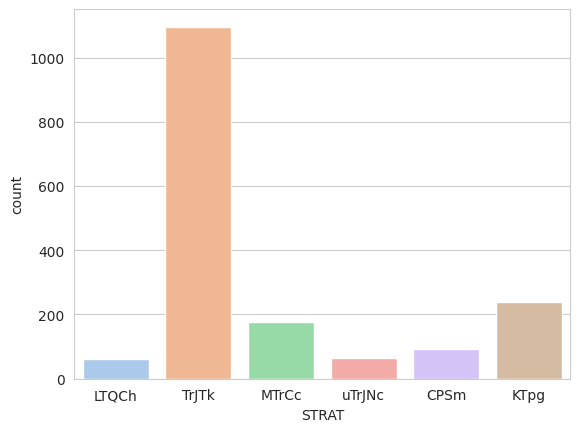

In [8]:
with sns.axes_style('whitegrid'):
  grafico = sns.countplot(data=quest, x='STRAT', palette="pastel")

Percebe-se que pode haver um viés de amostragem, uma vez que TrJTk está mais presente que os outros dados, numa ordem de grandeza muito maior. Porém isso é muito comum na geologia, uma vez que os pontos de amostragem dependem da coleta, grau de intemperismo, facilidade de acesso aos pontos de amostra, classificação do intérprete, entre outros fatores.
<br>
<br>



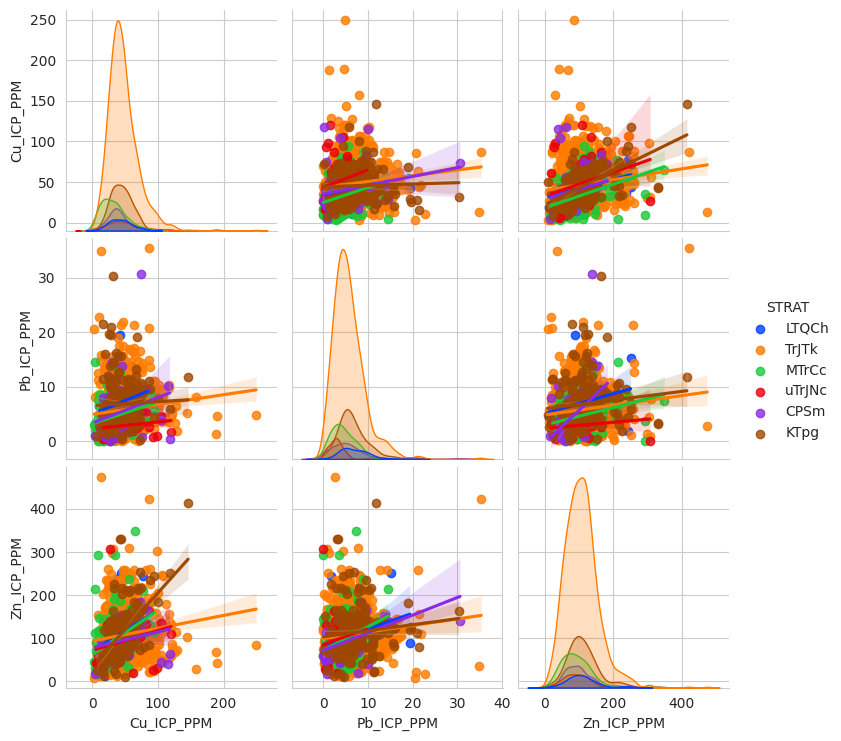

In [9]:
with sns.axes_style('whitegrid'):
  grafico = sns.pairplot(data=quest.drop(['LAT','LONG'], axis=1), hue="STRAT", palette="bright", kind='reg', diag_kind='kde')


**Comentário:**

Apesar do viés de amostragem de TrJNc roubar a cena nesses gráficos pela sua grande quantidade de amostras, as regressões lineares mostram que há correlação positiva entre as diferentes concentrações de elementos químicos.

**Data Wrangling**

Verificando se a base de dados tem valores faltantes, e tratando-os.

In [10]:
quest.isnull().sum()

LAT            0
LONG           0
STRAT          0
Cu_ICP_PPM     0
Pb_ICP_PPM    60
Zn_ICP_PPM     0
dtype: int64

In [11]:
quest.describe()

,LAT,LONG,Cu_ICP_PPM,Pb_ICP_PPM,Zn_ICP_PPM
count,1729.000000,1729.000000,1729.000000,1669.000000,1729.000000
mean,54.378633,-123.291742,44.546524,5.697627,104.986698
std,0.476532,0.491792,22.084590,3.667579,48.665024
min,53.195060,-124.992740,2.600000,0.010000,8.000000
25%,54.073600,-123.621480,30.410000,3.300000,72.100000
50%,54.428640,-123.264910,41.030000,5.110000,99.800000
75%,54.736290,-123.026130,54.710000,7.380000,128.000000
max,55.247780,-121.916790,249.600000,35.340000,474.100000


In [12]:
#substituindo os valores faltantes pela média do elemento Pb
quest_2 = quest.fillna(value=quest["Pb_ICP_PPM"].mean())

In [13]:
quest_2.isnull().sum()

LAT           0
LONG          0
STRAT         0
Cu_ICP_PPM    0
Pb_ICP_PPM    0
Zn_ICP_PPM    0
dtype: int64

 **Padronizando variáveis numéricas**

**Treino/Teste**

Separando a base de dados em treino e teste e utilizando uma proporção de 2/3 para treino e 1/3 para testes.



In [14]:
quest_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAT         1729 non-null   float64
 1   LONG        1729 non-null   float64
 2   STRAT       1729 non-null   object 
 3   Cu_ICP_PPM  1729 non-null   float64
 4   Pb_ICP_PPM  1729 non-null   float64
 5   Zn_ICP_PPM  1729 non-null   float64
dtypes: float64(5), object(1)
memory usage: 81.2+ KB


In [15]:
quest_2.describe().T

,count,mean,std,min,25%,50%,75%,max
LAT,1729.0,54.378633,0.476532,53.19506,54.07360,54.42864,54.73629,55.24778
LONG,1729.0,-123.291742,0.491792,-124.99274,-123.62148,-123.26491,-123.02613,-121.91679
Cu_ICP_PPM,1729.0,44.546524,22.084590,2.60000,30.41000,41.03000,54.71000,249.60000
Pb_ICP_PPM,1729.0,5.697627,3.603343,0.01000,3.40000,5.24000,7.24000,35.34000
Zn_ICP_PPM,1729.0,104.986698,48.665024,8.00000,72.10000,99.80000,128.00000,474.10000


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
predictors_train, predictors_test, target_train, target_test = train_test_split(
    quest_2.drop(["STRAT"], axis=1),
    quest_2["STRAT"],
    test_size=0.33,
    random_state=123
)

In [18]:
print(f'x (treino): {predictors_train.shape}')
print(f'y (treino): {target_train.shape}')
print(f'x (teste): {predictors_test.shape}')
print(f'y (teste): {target_test.shape}')

x (treino): (1158, 5)
y (treino): (1158,)
x (teste): (571, 5)
y (teste): (571,)


# **2. Modelagem**

Treinaremos um modelo de árvore de decisão com os dados de treino (2/3), com geração do gráfico de árvore do modelo treinado.

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model = DecisionTreeClassifier()

In [21]:
model = model.fit(predictors_train, target_train)

In [22]:
model.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['LAT', 'LONG', 'Cu_ICP_PPM', 'Pb_ICP_PPM', 'Zn_ICP_PPM'],
       dtype=object),
 'n_features_in_': 5,
 'n_outputs_': 1,
 'classes_': array(['CPSm', 'KTpg', 'LTQCh', 'MTrCc', 'TrJTk', 'uTrJNc'], dtype=object),
 'n_classes_': 6,
 'max_features_': 5,
 'tree_': <sklearn.tree._tree.Tree at 0x7fb55b277b40>}

In [23]:
#visualizando a arvore de decisao gerada
import graphviz
from sklearn import tree

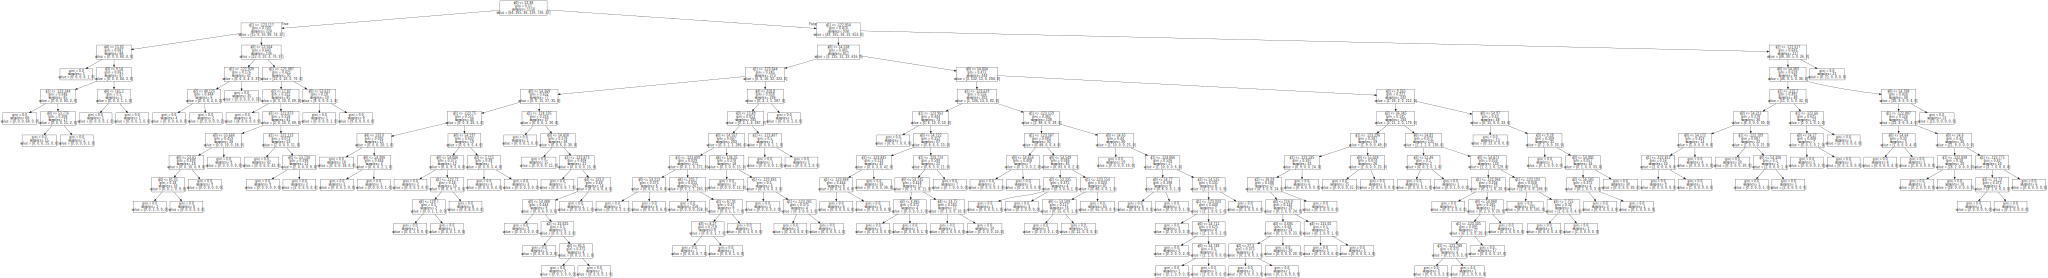

In [24]:
#visializando a árvore de decisão
tree_data = tree.export_graphviz(model, out_file=None)
graph = graphviz.Source(tree_data, format='png')
graph

**Avaliação**

In [ ]:
target_predicted = model.predict(predictors_test)

In [ ]:
target_predicted[0:5]

array(['KTpg', 'MTrCc', 'TrJTk', 'CPSm', 'TrJTk'], dtype=object)

In [ ]:
target_predicted.shape

(571,)

a. Matriz de Confusão

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix = confusion_matrix(target_test, target_predicted)
print(confusion_matrix)

[[ 21   3   2   0   3   0]
 [  6  59   0   0  10   0]
 [  2   0   7   1   4   0]
 [  0   0   0  50   5   2]
 [ 10  17   6   6 331   0]
 [  0   0   0   0   0  26]]


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

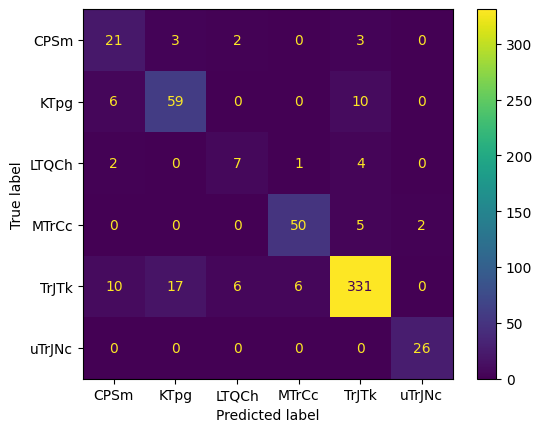

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_).plot()

plt.show()

A unidade geológica com mais acertos previstos pelo modelo foi a uTrJNC, com todas as amostras classificadas corretamente, porém essa unidade tem poucas amostras (1,50% do total).<br>
Já a unidade TrJTk, com um número expressivo de amostras, foi a segunda com maior número de acertos, equivalente a 90% de acertos.<br>
A unidade MTrCc teve 88% de acertos, KTpg 79%, CPSm 73% e LTQCh 50%.

Talvez a unidade LTQCh possa estar envolvida em mais erros por ser elacionada a rochas vulcânicas provenientes de eventos de derrames, isso faz com que tenha uma ampla distribuição espacial, o que implicaria em menor controle dos parâmetros de latitude e longitude quando comparadas às outras rochas. No mapa geológico, essa unidade é representada pela cor amarela, e ela é mais extensa que as outras unidades da bacia sedimentar.



b. Acurácia

In [ ]:
total = confusion_matrix.sum()
print(total)

571


In [ ]:
acertos = np.diag(confusion_matrix).sum()
print(acertos)

494


In [ ]:
acuracia = acertos / total
print(acuracia)

0.8651488616462347


In [ ]:
print(f"{round(100*acuracia,2)}%")

86.51%


A acurácia pode ser considerada boa o suficiente para esse modelo, porém em um caso de desbalanceamento dos dados essa acurácia não seria muito representativa, como por exemplo no caso de unidades geológicas de interesse sendo classificadas como falso negativo.

# **3. Conclusão**


O modelo de Árvore de Decisão foi aplicado a um conjunto de dados de sedimentos de corrente, com os atributos escolhidos de latitude e longitude, concentrações de zn, cu e pb, a fim de predizer a unidade geológica correspondente. <br>
Houve um viés de amostragem para a unidade TrTJk, com um número expressivo de amostras quando comparadas às outras unidades, porém isso é muito comum de ocorrer em dados geológicos. <br>
A unidade LTQCh pode estar envolvida em mais erros de predição por estar relacionada a rochas vulcânicas provenientes de derrames, que estão mais distribuídas regionalmente em relação às outras rochas, o que a faz não estar tão bem caracterizada pelo modelo quanto às outras. <br>
Pode-se dizer que esse modelo foi bem sucedido a predizer as unidades geológicas a partir dos parâmetros propostos, e a limpeza e o tratamento dos dados foi suficiente para que o modelo funcionasse bem também. A acurácia obtida foi de 86,51%.<br>
Além disso, esse estudo é de grande importância econômica, podendo ajudar a predizer novos locais de mineralizações porfiríticas de cu-au escondidos por camadas de tilitos, e pode ser usado em conjunto com outros estudos geofísicos, como perfuração de poços e usos de dados magnéticos e gravimétricos.

# **Bibliografia**

British Columbia. [British Columbia Digital Geology](https://www2.gov.bc.ca/gov/content/industry/mineral-exploration-mining/british-columbia-geological-survey/geology/bcdigitalgeology)<br>

Hayes, M.; Ferri, F. [Oil and Gas Opportunities in the Central British Columbia - Nechako Basin](https://www2.gov.bc.ca/assets/gov/farming-natural-resources-and-industry/natural-gas-oil/petroleum-geoscience/nechako_basin_interior.pdf)

Kushnir et al. (2012). [Rock Physical-Property Measurements for the Nechako Basin Oil and Gas Region, Central British Columbia](https://www.researchgate.net/publication/270279688_Rock_Physical-Property_Measurements_for_the_Nechako_Basin_Oil_and_Gas_Region_Central_British_Columbia_Parts_of_NTS_093B_C_E_F_G_K_L).

Palkovic, M. (2021).[Exploring use cases of machine learning in the geosciences](https://towardsdatascience.com/exploring-use-cases-of-machine-learning-in-the-geosciences-b72ea7aafe2)

Turner et al. [Geotour Guide for Prince George, British Columbia](https://mineralsed.ca/site/assets/files/3451/princegeorgegeotourguide.pdf)

Williams, A. [Potential Copper-gold Deposits Found in Prince George Region](https://www.princegeorgecitizen.com/local-news/potential-copper-gold-deposits-found-in-prince-george-region-5012129)